# Color Imaging

In [434]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
from scipy.constants import h, c, k
from scipy.io import loadmat

plt.rcParams["figure.figsize"] = (4,4)
plt.rcParams["savefig.dpi"] = 300
plt.rcParams["savefig.bbox"] = "tight"
plt.rcParams["savefig.pad_inches"] = 0.1

## CIE 1964

In [2]:
CIE = pd.read_csv("Data/CIE_xyz_1964_10deg.csv", header = None)
CIE_data = pd.DataFrame.to_numpy(pd.DataFrame(CIE))

In [3]:
CIE_wavelengths = CIE_data[:,0]
x_bar, y_bar, z_bar = CIE_data[:,1], CIE_data[:,2], CIE_data[:,3]
z_bar = np.nan_to_num(z_bar)

In [4]:
# Desired wavelengths
visible_wavelengths = np.arange(380, 780 + 1, 10)
spectrum_wavelengths = np.linspace(400, 800, len(CIE_wavelengths))

### Color matching functions

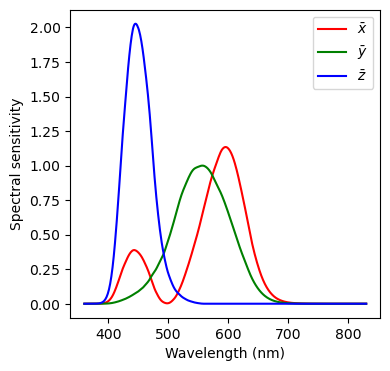

In [166]:
CIE_CMF = [x_bar, y_bar, z_bar]
labels = [r"$\bar{x}$", r"$\bar{y}$", r"$\bar{z}$"]
colors = ["red", "green", "blue"]

for i, CMF in enumerate(CIE_CMF):
    plt.plot(CIE_wavelengths, CMF, color = colors[i], label = labels[i])
    plt.xlabel("Wavelength (nm)")
    plt.ylabel("Spectral sensitivity")
    plt.legend()
    
plt.savefig("Results/CIE CMFs.png", dpi = 300)

### Tristimulus values

In [5]:
X, Y, Z, x, y, z = [], [], [], [], [], []

for wavelength in visible_wavelengths:
    
    # Calculate the Gaussian spectrum for specific wavelength
    amplitude, stdev = 1.0, 1.0
    light_spectrum = amplitude * np.exp(-((spectrum_wavelengths - wavelength)**2) / (2*stdev**2))
    
    # Locate the index of the target wavelength in the CMF data
    idx = np.argmin(np.abs(CIE_wavelengths - wavelength))
    
    # Calculate the tristimulus values for a specific wavelength
    X_val = np.trapz(x_bar[idx] * light_spectrum, spectrum_wavelengths)
    Y_val = np.trapz(y_bar[idx] * light_spectrum, spectrum_wavelengths)
    Z_val = np.trapz(z_bar[idx] * light_spectrum, spectrum_wavelengths)
    
    total_tristimulus = X_val + Y_val + Z_val
    x_val = X_val / total_tristimulus
    y_val = Y_val / total_tristimulus
    z_val = 1 - x_val - y_val
    
    X.append(X_val), Y.append(Y_val), Z.append(Z_val)
    x.append(x_val), y.append(y_val), z.append(z_val)

In [6]:
def xyz_chromaticity(wavelength, spectrum, standard_observer):
    trisim_XYZ = []
    for i in range(len(standard_observer)):
        integrand = spectrum * standard_observer[i]
        integral = np.trapz(integrand, wavelength)
        trisim_XYZ.append(integral)
    x, y, z = trisim_XYZ / np.sum(trisim_XYZ)
    return x, y

In [7]:
x_bound, y_bound = [], []

for wavelength in visible_wavelengths:
    dirac_delta_spec = np.zeros_like(CIE_wavelengths)
    dirac_delta_spec[np.where(CIE_wavelengths == wavelength)] = 1
    x, y = xyz_chromaticity(CIE_wavelengths, dirac_delta_spec, [x_bar, y_bar, z_bar])
    x_bound.append(x), y_bound.append(y)

### Planckian locus

In [8]:
def blackbody_radiation(wavelength, temperature):
    c1 = 2*np.pi*h*c*c
    c2 = h*c/k
    return c1/(wavelength**5) * 1/(np.exp(c2/wavelength/temperature) - 1)

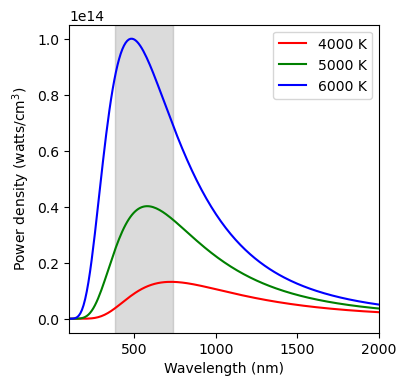

In [85]:
wavelength_vals = np.linspace(100, 10000, 1000)
temperature_vals = [4000, 5000, 6000]
colors = ["red", "green", "blue"]
spectrum_vals = []

for temp in temperature_vals:
    blackbody_spectrum = blackbody_radiation(wavelength_vals * 1e-9, temp)
    spectrum_vals.append(blackbody_spectrum)

fig, ax = plt.subplots()
    
for (i, temp), color in zip(enumerate(temperature_vals), colors):
    ax.plot(wavelength_vals, spectrum_vals[i], label = "{:.0f} K".format(temp), color = color)
    ax.axvspan(380, 740, alpha = 0.10, color = "gray")
    ax.set(xlabel = "Wavelength (nm)", ylabel = "Power density (watts/$\mathrm{cm}^3$)", xlim = (100, 2000))
    ax.legend()
    
plt.savefig("Results/blackbody radiation.png", dpi = 300)

In [9]:
# Desired temperatures
blackbody_temps = np.arange(1000, 10001, 1000)
x_locus, y_locus = [], []

for temp in blackbody_temps:
    blackbody_spectrum = blackbody_radiation(CIE_wavelengths * 1e-9, temp)
    x, y = xyz_chromaticity(CIE_wavelengths, blackbody_spectrum, [x_bar, y_bar, z_bar])
    x_locus.append(x), y_locus.append(y)

### CIE 1964 $xy$ chromaticity

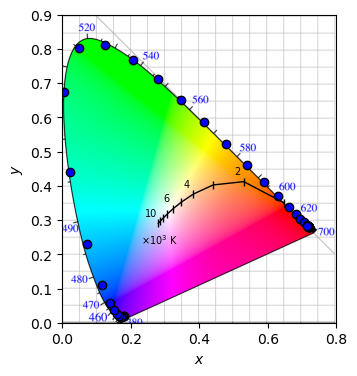

In [430]:
CIExy_tongue = plt.imread("CIExy.png")

plt.imshow(CIExy_tongue, extent = (0, 0.8, 0, 0.9))
plt.scatter(x_bound, y_bound, color = "blue", edgecolor = "black")
plt.plot(x_locus, y_locus, linewidth = 1, marker = "|", color = "black")
plt.xlabel("$x$")
plt.ylabel("$y$")

for i, mag in enumerate(blackbody_temps):
    if i % 2 == 1:
        if (mag // 1000) != 8:
            plt.annotate(str(mag//1000), (x_locus[i] - 0.02, y_locus[i] + 0.03), fontsize = 7,
                 horizontalalignment = "center", verticalalignment = "center")
            
plt.text(0.23, 0.23, r"$\times 10^3$ K", fontsize = 7)
plt.savefig("Results/CIExy tongue replicated.png", dpi = 300)

***
## CIE D65 Illuminant

In [285]:
CIE_D65 = np.genfromtxt("Data/CIE_std_illum_D65.csv", delimiter = ",", unpack = True).T
D65_wavelengths, D65_spectrum = CIE_D65[:,0], CIE_D65[:,1]

Code below taken from http://www.noah.org/wiki/Wavelength_to_RGB_in_Python. This converts a given wavelength of light to an approximate RGB color value. The wavelength must be given in nanometers in the range from 380 nm through 750 nm (789 THz through 400 THz). Based on code by [Dan Bruton](http://www.physics.sfasu.edu/astro/color/spectra.html). Additionally alpha value set to 0.5 outside range.

In [180]:
def wavelength_to_rgb(wavelength, gamma = 0.8):
    wavelength = float(wavelength)
    if wavelength >= 380 and wavelength <= 750: A = 1.
    else: A=0.5
    if wavelength < 380: wavelength = 380.
    if wavelength > 750: wavelength = 750.
    if wavelength >= 380 and wavelength <= 440:
        attenuation = 0.3 + 0.7 * (wavelength - 380) / (440 - 380)
        R = ((-(wavelength - 440) / (440 - 380)) * attenuation) ** gamma
        G = 0.0
        B = (1.0 * attenuation) ** gamma
    elif wavelength >= 440 and wavelength <= 490:
        R = 0.0
        G = ((wavelength - 440) / (490 - 440)) ** gamma
        B = 1.0
    elif wavelength >= 490 and wavelength <= 510:
        R = 0.0
        G = 1.0
        B = (-(wavelength - 510) / (510 - 490)) ** gamma
    elif wavelength >= 510 and wavelength <= 580:
        R = ((wavelength - 510) / (580 - 510)) ** gamma
        G = 1.0
        B = 0.0
    elif wavelength >= 580 and wavelength <= 645:
        R = 1.0
        G = (-(wavelength - 645) / (645 - 580)) ** gamma
        B = 0.0
    elif wavelength >= 645 and wavelength <= 750:
        attenuation = 0.3 + 0.7 * (750 - wavelength) / (750 - 645)
        R = (1.0 * attenuation) ** gamma
        G = 0.0
        B = 0.0
    else:
        R = 0.0
        G = 0.0
        B = 0.0
    return (R,G,B,A)

In [207]:
# Initialize the RGB colormap
clim = (350,780)
norm = plt.Normalize(*clim)
wl = np.arange(clim[0],clim[1]+1,2)
color_list = list(zip(norm(wl), [wavelength_to_rgb(w) for w in wl]))
spectral_map = colors.LinearSegmentedColormap.from_list("spectrum", colorlist)

y_extent = np.linspace(-0.15, 120, 1000)
x_map, y_map = np.meshgrid(CIE_D65[:,0], y_extent)
extent = (np.min(CIE_D65[:,0]), np.max(CIE_D65[:,0]), np.min(y_extent), np.max(y_extent))

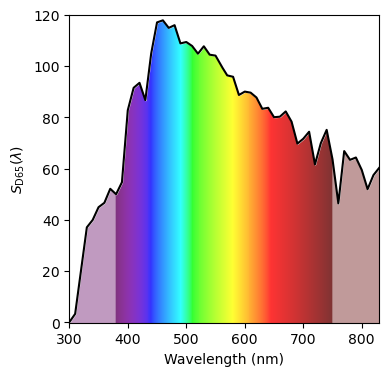

In [209]:
fig, ax = plt.subplots()

ax.plot(CIE_D65[:,0], CIE_D65[:,1], color = "black")
ax.imshow(x_map, clim = clim, extent = extent, cmap = spectral_map, alpha = 0.8, aspect = "auto")
ax.fill_between(CIE_D65[:,0], CIE_D65[:,1], 120, color = "white")
ax.set(xlabel = "Wavelength (nm)", ylabel = r"$S_{\mathrm{D65}} (\lambda)$")

fig.savefig("Results/D65 illuminant distribution.png", dpi = 300)

## CIE $u'v'$ color space

In [297]:
def uv_chromaticity(x, y):
    denom = -2*x + 12*y + 3
    u_prime = 4*x / denom
    v_prime = 9*y / denom
    return u_prime, v_prime

In [301]:
u_bound, v_bound = [], []

for i in range(len(x_bound)):
    u_p, v_p = uv_chromaticity(x_bound[i], y_bound[i])
    u_bound.append(u_p), v_bound.append(v_p)

In [303]:
u_locus, v_locus = [], []

for i in range(len(x_locus)):
    u_p, v_p = uv_chromaticity(x_locus[i], y_locus[i])
    u_locus.append(u_p), v_locus.append(v_p)

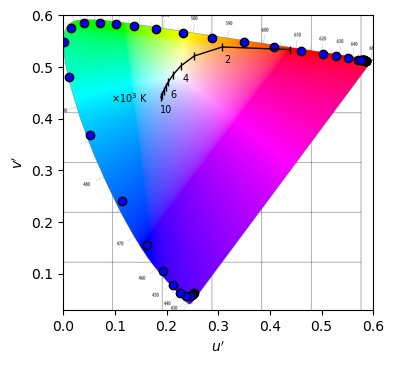

In [433]:
CIELuv_diagram = plt.imread("CIE Luv.png")

plt.imshow(CIELuv_diagram, extent = (0, 0.6, 0.03, 0.6))
plt.scatter(u_bound, v_bound, color = "blue", edgecolor = "black")
plt.plot(u_locus, v_locus, linewidth = 1, marker = "|", color = "black")
plt.xlabel("$u'$")
plt.ylabel("$v'$")

for i, mag in enumerate(blackbody_temps):
    if i % 2 == 1:
        if (mag // 1000) != 8:
            plt.annotate(str(mag//1000), (u_locus[i] + 0.01, v_locus[i] - 0.025), fontsize = 7,
                 horizontalalignment = "center", verticalalignment = "center")
            
plt.text(0.093, 0.43, r"$\times 10^3$ K", fontsize = 7)
plt.savefig("Results/CIE Luv diagram replicated.png", dpi = 300)

## Munsell color chips

In [449]:
munsell_data = loadmat("Data/munsell400_700_5.mat")
munsell_spectrum = pd.DataFrame(munsell_data["munsell"])
munsell_coords = pd.DataFrame(munsell_data["C"])